In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset

In [3]:
ds = load_dataset("food101")

In [4]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]
"baklava"

'baklava'

In [5]:
from transformers import AutoImageProcessor

In [6]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [7]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

In [8]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

In [9]:
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

In [10]:
val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)

In [11]:
def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [12]:
def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [13]:
train_ds = ds["train"]
val_ds = ds["validation"]

In [14]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [15]:
import torch

In [16]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [17]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

In [18]:
base_model_id = "google/vit-base-patch16-224-in21k"

In [19]:
model = AutoModelForImageClassification.from_pretrained(
    base_model_id,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Lora Peft Methods

In [29]:
from peft import LoraConfig, LoHaConfig, LoKrConfig, AdaLoraConfig, get_peft_model

## Lora

In [21]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)

In [22]:
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 667,493 || all params: 86,543,818 || trainable%: 0.7713


In [ ]:
peft_model_id = "vit-base-patch16-224-in21k-lora"

## LoHa

In [59]:
config = LoHaConfig(
    r=16,
    alpha=16,
    target_modules=["query", "value"],
    module_dropout=0.1,
    modules_to_save=["classifier"],
)

In [60]:
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 1,257,317 || all params: 87,133,642 || trainable%: 1.4430


In [106]:
peft_model_id = "vit-base-patch16-224-in21k-loHa"

## LoKr

In [82]:
config = LoKrConfig(
    r=16,
    alpha=16,
    target_modules=["query", "value"],
    module_dropout=0.1,
    modules_to_save=["classifier"],
)

In [83]:
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 116,069 || all params: 85,992,394 || trainable%: 0.1350


In [84]:
peft_model_id = "vit-base-patch16-224-in21k-loKr"

## AdaLora

In [30]:
config = AdaLoraConfig(
    r=8,
    init_r=12,
    tinit=200,
    tfinal=1000,
    deltaT=10,
    target_modules=["query", "value"],
    modules_to_save=["classifier"],
)

In [31]:
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 520,325 || all params: 86,396,674 || trainable%: 0.6023


In [32]:
peft_model_id = "vit-base-patch16-224-in21k-AdaLora"

## Training

In [33]:
from transformers import TrainingArguments, Trainer

In [34]:
batch_size = 128

In [35]:
args = TrainingArguments(
    peft_model_id,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    label_names=["labels"],
)

/home/geshi/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [36]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    data_collator=collate_fn,
)

In [37]:
trainer.train()

[2024-09-06 11:53:42,208] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  using untested triton version (2.2.0), only 1.0.0 is known to be compatible


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/geshi/.netrc


/home/geshi/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.865300,0.492152
2,0.745300,0.418513
3,0.686400,0.393554
4,0.640200,0.374812
5,0.619400,0.368370


/home/geshi/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/geshi/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/geshi/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/geshi/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/geshi/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/geshi/.local/lib/python3.

TrainOutput(global_step=370, training_loss=0.8297013875600454, metrics={'train_runtime': 2666.1272, 'train_samples_per_second': 142.06, 'train_steps_per_second': 0.139, 'total_flos': 2.955413189094912e+19, 'train_loss': 0.8297013875600454, 'epoch': 5.0})

# Upload the model

In [38]:
from huggingface_hub import notebook_login, login

In [39]:
notebook_login

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/geshi/.cache/huggingface/token
Login successful


In [40]:
trainer.push_to_hub(peft_model_id)

events.out.tfevents.1725646528.cajal.58195.3:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

events.out.tfevents.1725648822.cajal.80564.0:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/2.09M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/geshijoker/vit-base-patch16-224-in21k-AdaLora/commit/120132abae13d6378bbf4cda8440f369f55f1a99', commit_message='vit-base-patch16-224-in21k-AdaLora', commit_description='', oid='120132abae13d6378bbf4cda8440f369f55f1a99', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [41]:
from peft import PeftConfig, PeftModel
from transformers import AutoImageProcessor
from PIL import Image
import requests

In [42]:
config = PeftConfig.from_pretrained(f"geshijoker/{peft_model_id}")

adapter_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

In [43]:
config

AdaLoraConfig(peft_type=<PeftType.ADALORA: 'ADALORA'>, auto_mapping={'base_model_class': 'PeftModel', 'parent_library': 'peft.peft_model'}, base_model_name_or_path=None, revision=None, task_type=None, inference_mode=True, r=8, target_modules={'query', 'value'}, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=['classifier'], init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern=None, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, target_r=8, init_r=12, tinit=200, tfinal=1000, deltaT=10, beta1=0.85, beta2=0.85, orth_reg_weight=0.5, total_step=None)

In [44]:
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

OSError: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [46]:
model = AutoModelForImageClassification.from_pretrained(
    base_model_id,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
base_model_id

'google/vit-base-patch16-224-in21k'

In [47]:
model = PeftModel.from_pretrained(model, f"geshijoker/{peft_model_id}")

adapter_model.safetensors:   0%|          | 0.00/2.09M [00:00<?, ?B/s]

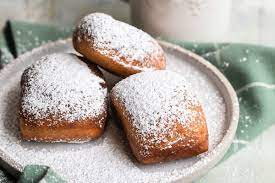

In [48]:
url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [49]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [50]:
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [51]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: ramen
